# ADTLSWI

Differential time-lapse surface wave inversion using a linear approximation of Rayleigh wave phase velocity 

Application on MUSC data: baseline C25, repeatline C45. Measured in 07/2019.

## 1. Read SU data

Measured seismogram for C25 and C45 models. "read_su_data" function can read SU data in Python and export dispersion diagram and dispersion curve.

In [11]:
from math_func import read_su_data

#-> SU files
c25_filename = "data/C25.su"
c45_filename = "data/C45.su"

#-> parameters for SU operations
dx = 1; offset = 12              # receiver  information
tmin = 0; tmax = 0.5             # time window
fmin = 35; fmax = 90            # frequency range
vmin = 500; vmax = 1200; nv = 700 # velocity range
freq = [1., 10., 100., 150.]; amps = [0., 1.0, 1.0, 0.] # filter parameters

#-> read data
f,sismo_c25,vph_c25,diagram_c25 = read_su_data(c25_filename, dx, offset, tmax, tmin, 
                                                     fmax, fmin, vmax, vmin, nv, freq, amps, detail="off")
_,sismo_c45,vph_c45,diagram_c45 = read_su_data(c45_filename, dx, offset, tmax, tmin, 
                                                     fmax, fmin, vmax, vmin, nv, freq, amps, detail="off")

DTLSWI-DD is very time-consuming because dispersion diagram is calculated for each inverted model. In this example, NA inversion has few iterations for time-saving, but the inversions are not converged.

In [12]:
#-> vectors setting

import numpy as np

#-> information from SU header 
dt = 100/1e6           #baseline.header[0]['dt']
nt, ntraces = 5400, 90 #baseline.shape

#-> time
t = np.linspace(0, (nt-1)*dt, nt)

#-> offset
x = np.linspace(offset, (ntraces-1)*dx+offset, ntraces)

# velocity vector
v = np.linspace(vmin, vmax, nv)

## 2. Sensitivity kernel of baseline

Model parameters of baseline are known to calculate its sensitivity kernel.

In [13]:
import numpy as np
from forward import mat_disperse

# model parameters
thk = np.array([7.2], dtype = float)
dns = np.array([450, 1300], dtype = float)
cvp = np.array([1300, 2048], dtype = float)
cvs = np.array([708.0, 990.0])

#-> sensitivity kernel calculation
vr,r,z,zdvrvs,zdvrvp,zdvrrho,dvrvs,dvrvp,dvrrho = mat_disperse(thk, dns, cvp, cvs, f, opt=3)

#-> reshape matrix
vr = vr.reshape(len(vr))
zdvrvs,zdvrvp,zdvrrho = np.real(zdvrvs), np.real(zdvrvp), np.real(zdvrrho)
dvrvs,dvrvp,dvrrho = np.real(dvrvs), np.real(dvrvp), np.real(dvrrho)

## 3. ADTLSWI

ADTLSWI has a very low cumputational time sin ce the sentivity kernel is calculated only once for the baseline. 

Parameter space mmin and mmax is defined as model parameter variation range between baseline and repeatline, instead of model parameter range.

In [23]:
from NA_inversion import sensitivity_inversion

#-> inversion parameters
ni=20       # number of iterations
n0=50       # number of initial random model samples
n1=20       # number of best models used at each iteration
n2=20       # number of new models in the neighborhood of previous best models

#-> only Vs are searched
mmin = np.array([-30, -10])
mmax = np.array([30, 110])

#-> inversion input data
diff_vph = vph_c45 - vph_c25

#-> ADTLSWI
mo_c45, Pmo_c45, pchrono_c45 = sensitivity_inversion(diff_vph,dvrvs,mmin,mmax,ni,n0,n1,n2)

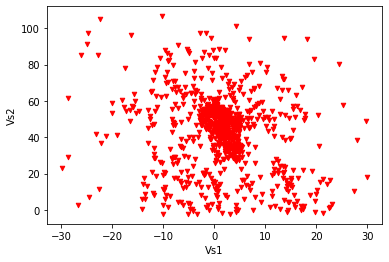

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(pchrono_c45/max(pchrono_c45), linewidth = 3)
plt.xlabel("iteration number"); plt.ylabel("misfit")

plt.figure()
plt.xlabel("Vs1"); plt.ylabel("Vs2")
plt.scatter(mo_c45[:,0], mo_c45[:,1], s = 20, color = "red", marker = "v")